# Trabajo final - Escaneador de documentos

**Alumnos:** Borja Sanchis Tomás y Abel Vidal Ripoll

Explicación de que trata el trabajo, resumen del funcionamiento y objetivos del proyecto.

Explicación de los paquetes importados 

* Transform: Transformar la imagen una vez obtenida los 4 borders (Recortar la imagen)
* Imutils: Usado para reescalar la imagen para trabajar mejor
* numpy: Utilizado para trabajar con matrices (Una imagen es una matriz)
* matplotlib: Utilizado para visualizar las imagenes poco a poco y entender todo de una manera más visual
* math: Para usar el acos para calcular el angulo entre vectores (esquinas)
* cv2: Uitlizado para todo el tema de tratamiento de imagen, abrir, aplicar filtros y para encontrar los bordes
* lsd: Usado para detectar segmentos de línea en la imagen procesada.
* os: Usado para obtener rutas y guardar fichero.

In [32]:
from pyimagesearch import transform
from pyimagesearch import imutils
from scipy.spatial import distance as dist
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
import cv2
from pylsd.lsd import lsd
import os

## Escanear documento

Con estas celdas iremos explicando paso a paso el proceso para poder escanear correctamente un documento

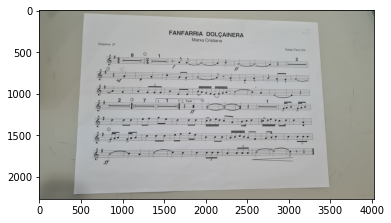

In [33]:
image_path = "sample_images\partitura2.jpg"
RESCALED_HEIGHT = 500.0
OUTPUT_DIR = 'scaned'

image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
_=plt.imshow(image)

Definimos la ruta del fichero que vamos a escanear y rescalamos su altura, definimos la ruta de donde se guardará el fichero escaneado más adelante. Luego cargamos la imagen y la visualizamos

In [34]:
ratio = image.shape[0] / RESCALED_HEIGHT
orig = image.copy()
rescaled_image = imutils.resize(image, height = int(RESCALED_HEIGHT))

Calculamos la proporción de reescalado para la altura de la imagen, hacemos una copia de la imagen original, y luego reescalamos la imagen a la altura deseada manteniendo la proporción. En este caso la imagen no hay que reescalar mucho la imagen, en la siguiente imagen vereis que la imagen se ha reescalado con éxito

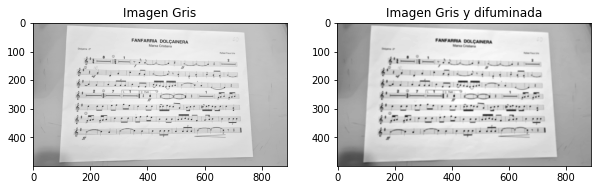

In [35]:
MORPH = 9
CANNY = 84
HOUGH = 25
IM_HEIGHT, IM_WIDTH, _ = rescaled_image.shape
gray = cv2.cvtColor(rescaled_image, cv2.COLOR_RGB2GRAY)
_=plt.figure(figsize=(10, 5))
plt.subplot(121)
_=plt.imshow(gray,cmap='gray')
_=plt.title('Imagen Gris')
gray = cv2.GaussianBlur(gray, (7,7), 0)
plt.subplot(122)
_=plt.imshow(gray,cmap='gray')
_=plt.title('Imagen Gris y difuminada')

Definimos unas constantes y obtenemos la constante de altura y anchura que nos serviran a futuro, luego la pasamos a grises y difuminamos con filtro gaussiano. Esto es bastante util porque al escanear es infinitamente más sencillo escanear en escala de grises y al difuminar reducimos el ruido y nos ayuda a detectar mejor los bordes

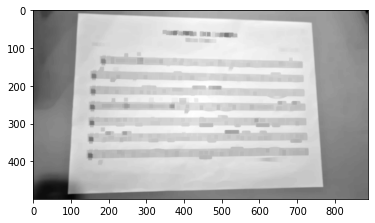

In [36]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(MORPH,MORPH))

dilated = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
_=plt.imshow(dilated,cmap="gray")

Creamos una estructura rectangular del tamaño definido antes MORPH, visto en la práctica 4 Morfología y máscaras, esta estructura es la que usaremos para dilatar la imagen en escala de grises y difuminada, la dilatación ayuda a eliminar posibles agujeros entre segmentos de borde. Esto nos sirve para una deteccion del contorno más precisa.

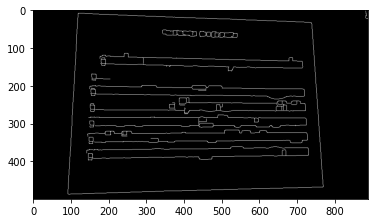

In [37]:
edged = cv2.Canny(dilated, 0, CANNY)
_=plt.imshow(edged,cmap="gray")

Usando el filtro CANNY nombrado en la práctica 2b filtrado, obtenemos los bordes, como se muestra en la imagen es un algoritmo que funciona muy bien, los bordes del folio se han detectado correctamente.

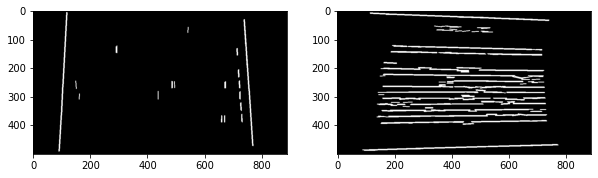

In [38]:
lines = lsd(edged)
corners = []
# Separar lineas horizontales de las verticales y guardarlas en canvas(lienzos) distintos
lines = lines.squeeze().astype(np.int32).tolist()
horizontal_lines_canvas = np.zeros(edged.shape, dtype=np.uint8)
vertical_lines_canvas = np.zeros(edged.shape, dtype=np.uint8)
for line in lines:
    x1, y1, x2, y2, _ = line
    if abs(x2 - x1) > abs(y2 - y1):
        (x1, y1), (x2, y2) = sorted(((x1, y1), (x2, y2)), key=lambda pt: pt[0])
        cv2.line(horizontal_lines_canvas, (max(x1 - 5, 0), y1), (min(x2 + 5, edged.shape[1] - 1), y2), 255, 2)
    else:
        (x1, y1), (x2, y2) = sorted(((x1, y1), (x2, y2)), key=lambda pt: pt[1])
        cv2.line(vertical_lines_canvas, (x1, max(y1 - 5, 0)), (x2, min(y2 + 5, edged.shape[0] - 1)), 255, 2)
_=plt.figure(figsize=(10, 5))
plt.subplot(121)
_=plt.imshow(vertical_lines_canvas,cmap='gray')
plt.subplot(122)
_=plt.imshow(horizontal_lines_canvas,cmap='gray')

Utilizando el algoritmo de Detección de Segmentos de Línea (LSD) conseguimos que todas las líneas detectadas se separan en líneas horizontales y verticales, esto lo conseguimos con la conficion **if abs(x2-x1) > abs(y2-y1)**, ¿como podemos diferenciar si es horizontal o vertical? Muy fácil, si la diferencia de coordenadas **"x"** es mayor que la difernecia de coordenadas **"y"** significa que la linea que vemos es horizontal, y luego la dibujamos en el lienzo, si no es asi, es decir, que la resta de **"x"** es menor que la resta de **"y"**, la linea **"y"** (vertical) es más grande por lo que la linea será vertical.
Por último guardamos en un lienzo cada tipo de linea(horizontal y vertical) y mostramos las dos

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


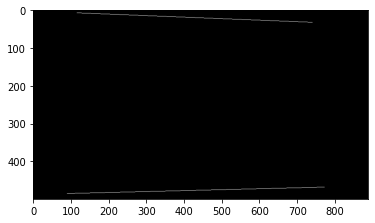

In [39]:
lines = []
# Encontrar lineas horizontales (connected-components -> bounding boxes -> final lines)
(contours, hierarchy) = cv2.findContours(horizontal_lines_canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=lambda c: cv2.arcLength(c, True), reverse=True)[:2]
horizontal_lines_canvas = np.zeros(edged.shape, dtype=np.uint8)
for contour in contours:
    contour = contour.reshape((contour.shape[0], contour.shape[2]))
    min_x = np.amin(contour[:, 0], axis=0) + 2
    max_x = np.amax(contour[:, 0], axis=0) - 2
    left_y = int(np.average(contour[contour[:, 0] == min_x][:, 1]))
    right_y = int(np.average(contour[contour[:, 0] == max_x][:, 1]))
    lines.append((min_x, left_y, max_x, right_y))
    cv2.line(horizontal_lines_canvas, (min_x, left_y), (max_x, right_y), 1, 1)
    corners.append((min_x, left_y))
    corners.append((max_x, right_y))
    
_=plt.imshow(horizontal_lines_canvas,cmap='gray')
#Hacemos un print para observar que es una matriz binaria (0 negro y 1 blanco) 
print(vertical_lines_canvas[0:4])

Vamos a eliminar el ruido, para lograrlo tenemos que volver a trazar un lienzo sobre el lienzo de antes, pero esta vez delimitando sobre donde queremos dibujar, para lograr esto tenemos que marcar el máximo y minimo del eje x antes dibujado (Ya que al buscar escanear un documento las posibles lineas detectadas estaran siempre dentro del folio), cogemos el máximo y mínimo del contorno del eje x y ponemos un margen de error de +-2px. Con esto delimitamos la zona del nuevo lienzo solo a los contornos que se encuentren en el minimo de x y en el máximo. Viendo la imagen de antes vemos que todas las lineas horizontales de ruido no llegaban a los limites, por lo que ahora en el nuevo lienzo no las dibujamos.

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


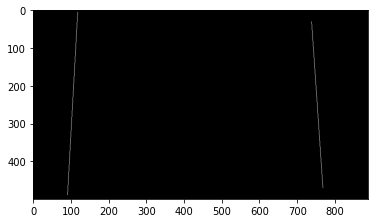

In [40]:
# find the vertical lines (connected-components -> bounding boxes -> final lines)
(contours, hierarchy) = cv2.findContours(vertical_lines_canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=lambda c: cv2.arcLength(c, True), reverse=True)[:2]
vertical_lines_canvas = np.zeros(edged.shape, dtype=np.uint8)
for contour in contours:
    contour = contour.reshape((contour.shape[0], contour.shape[2]))
    min_y = np.amin(contour[:, 1], axis=0) + 2
    max_y = np.amax(contour[:, 1], axis=0) - 2
    top_x = int(np.average(contour[contour[:, 1] == min_y][:, 0]))
    bottom_x = int(np.average(contour[contour[:, 1] == max_y][:, 0]))
    lines.append((top_x, min_y, bottom_x, max_y))
    cv2.line(vertical_lines_canvas, (top_x, min_y), (bottom_x, max_y), 1, 1)
    corners.append((top_x, min_y))
    corners.append((bottom_x, max_y))
_=plt.imshow(vertical_lines_canvas,cmap='gray')
print(vertical_lines_canvas[0:4])

Realizamos el mismo proceso de antes pero esta vez con las lineas verticales

In [41]:
# find the corners
corners_y, corners_x = np.where(horizontal_lines_canvas + vertical_lines_canvas == 2)
corners += zip(corners_x, corners_y)

Sumamos las matrices de las lineas horizontales y verticales y donde los valores suman 2 es donde encontramos que se cruzan las lineas, la condicion **np.where** nos dice donde se cumple la condicion, en nuestro caso donde la suma vale 2, ya que al ser una matriz binaria cuando sume 2 significa que se cruzan esas lineas. Luego con **corners_y** y **corners_x** los combinamos en un iterable de tuplas. Cada tupla contiene un elemento de cada iterable, esto se hace con la función zip.

In [42]:
def filter_corners(corners, min_dist=20):
        """Filtra las esquinas que están dentro de una distancia mínima de otras."""
        def predicate(representatives, corner):
            return all(dist.euclidean(representative, corner) >= min_dist
                       for representative in representatives)

        filtered_corners = []
        for c in corners:
            if predicate(filtered_corners, c):
                filtered_corners.append(c)
        return filtered_corners
test_corners = filter_corners(corners)

Con la función **filter_corners** filtramos las esquinas que están demasiado cerca unas de otras, asegurando que cada esquina en la lista final está a al menos una distancia mínima (min_dist) de las demás. 
La función **predicate** comprueba mediante la distnacia euclidiana si la esquina **c**, está a una distancia mínima (**min_dist**) de todas las esquinas ya almacenadas en **filtered_corners**. Si la condición se cumple (es decir, si **predicate** devuelve True), entonces la esquina **c** se añade a la lista **filtered_corners**. Este proceso se repite para cada esquina en corners, de tal manera que al finalizar tendremos las 4 esquinas

In [43]:
approx_contours = []

if len(test_corners) >= 4:
    quads = []

    for quad in itertools.combinations(test_corners, 4):
        points = np.array(quad)
        points = transform.order_points(points)
        points = np.array([[p] for p in points], dtype = "int32")
        quads.append(points)

En esta condición si hay al menos 4 esquinas en **test_corners** hacemos una condición en la que utilizamos **itertools.combinations** para generar todas las posibles combinaciones de 4 esquinas distintas de la lista test_corners. Cada combinación es una tupla de 4 puntos, luego guardamos esos puntos y por último ordenamos y reformateamos el orden y esos mismo puntos ordenados y reformateados se añaden a la lista **quads**. Esta lista almacenará todas las combinaciones de 4 puntos que forman cuadriláteros.

In [44]:
def angle_between_vectors_degrees(u, v):
        """Devuelve el ángulo entre dos vectores en grados."""
        return np.degrees(math.acos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))))

Con esta función logramos calcular el ángulo entre el vector avec y cvec que a su vez es una resta de los arrays de los cuadrilateros que más adelante entenderéis

In [45]:
def get_angle(p1, p2, p3):
        """
        Devuelve el ángulo entre el segmento de línea desde p2 hasta p1 y el segmento de línea desde p2 hasta p3 en grados.
        """
        a = np.radians(np.array(p1))
        b = np.radians(np.array(p2))
        c = np.radians(np.array(p3))

        avec = a - b
        cvec = c - b
        

        return angle_between_vectors_degrees(avec, cvec)

Esta función calcula el ángulo entre dos segmentos de línea dados por los puntos p1, p2 y p3. 

Primero, convierte las coordenadas de los puntos a radianes utilizando **np.radians**. Luego, calcula los vectores que representan estos segmentos de línea restando las coordenadas de los puntos. 

Finalmente, utiliza la función **angle_between_vectors_degrees** para calcular el ángulo entre estos dos vectores en grados y lo devuelve. 

In [46]:
def angle_range(quad):
        """
        Devuelve el rango entre los ángulos interiores máximo y mínimo de un cuadrilátero. 
        El cuadrilátero de entrada debe ser un array de NumPy con vértices ordenados en sentido horario 
        comenzando por el vértice superior izquierdo
        """
        tl, tr, br, bl = quad
        ura = get_angle(tl[0], tr[0], br[0])
        ula = get_angle(bl[0], tl[0], tr[0])
        lra = get_angle(tr[0], br[0], bl[0])
        lla = get_angle(br[0], bl[0], tl[0])

        angles = [ura, ula, lra, lla]
        return np.ptp(angles)      

Esta función calcula el rango entre los ángulos máximo y mínimo en un cuadrilátero dado. 

Primero, se extraen los vértices del cuadrilátero, y luego se calculan los ángulos interiores entre segmentos de línea adyacentes utilizando la función **get_angle**, que retorna el ángulo en grados. Estos ángulos se almacenan en una lista. 

Finalmente, se calcula el rango entre el ángulo máximo y el mínimo utilizando la función **np.ptp**, que devuelve la diferencia entre el valor máximo y mínimo de una matriz o lista. El resultado final es el rango entre los ángulos máximo y mínimo en el cuadrilátero.

In [47]:
# Obtener los cinco cuadriláteros principales por área.
quads = sorted(quads, key=cv2.contourArea, reverse=True)[:5]
# Ordenar los cuadriláteros candidatos por su rango de ángulo, lo que ayuda a eliminar valores atípicos.
quads = sorted(quads, key=angle_range)

Seleccionamos los cinco cuadriláteros principales basados en su área y luego ordenamos los cuadriláteros candidatos según su rango de ángulo. En la primera línea, utilizamos la función **cv2.contourArea** para calcular el área de cada cuadrilátero en la lista **quads** previamente obtenida, luego los ordenamos de mayor a menor área. 
Seleccionamos solamente los cinco cuadriláteros con las áreas más grandes. 
En la segunda línea, ordenamos los cuadriláteros restantes según su rango de ángulo utilizando la función **angle_range**, lo que nos ayuda a eliminar valores atípicos al priorizar aquellos con un rango de ángulo más pequeño.

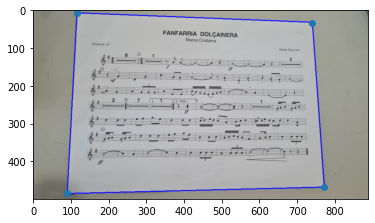

In [48]:
def is_valid_contour(cnt, IM_WIDTH, IM_HEIGHT):
        """Devuelve True si el contorno cumple con todos los requisitos establecidos en la creacion de instancias"""
        return (len(cnt) == 4 and cv2.contourArea(cnt) > IM_WIDTH * IM_HEIGHT * MIN_QUAD_AREA_RATIO and angle_range(cnt) < MAX_QUAD_ANGLE_RANGE)

MIN_QUAD_AREA_RATIO=0.25
MAX_QUAD_ANGLE_RANGE=40
approx = quads[0]
if is_valid_contour(approx, IM_WIDTH, IM_HEIGHT):
    approx_contours.append(approx)
    
cv2.drawContours(rescaled_image, [approx], -1, (20, 20, 255), 2)
plt.scatter(*zip(*test_corners))
plt.imshow(rescaled_image)
plt.show()

Como observamos las 4 esquinas se han detectado correctamente, aunque no es un proceso perfecto ya que por ejemplo al coger un folio doblado por las esquinas no uniremos siempre bien los puntos entre esquinas, aunque es un proceso bastante preciso, hemos elegido un folio doblado, con sombras y no centrado para ver el peor caso posible, y pese a eso ha hecho un muy buen trabajo.

In [49]:
(cnts, hierarchy) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
print(hierarchy)

[[[ 1 -1 -1 -1]
  [-1  0 -1 -1]]]


Buscamos los contornos de edged visto arriba y nos devuelve una lista de los contornos encontrados y hierarchy nos devuelve una estructura de datos que describe la relación jerárquica entre los contornos, nos devuelve algo asi (hierarchy = [ [Next, Previous, First_Child, Parent] ]), esto nos dice si hay o no hay un contorno siguiente, anterior, o el nivel inferior de jerarquia y el nivel superior de jerarquia. Para entenderlo mejor pongamos un ejemplo.

Por ejemplo, si hierarchy [i]= [2, -1, 4, -1], esto significa que:

* El contorno i tiene como siguiente contorno al contorno 2.
* No hay un contorno anterior (Previous es -1).
* Tiene como primer hijo al contorno 4.
* No tiene un contorno padre (Parent es -1).

Esta información nos es muy útil para analizar la estructura jerárquica de los contornos, nos sirve para distinguir entre contornos exteriores e interiores.

In [50]:
# loop over the contours
for c in cnts:
    # approximate the contour
    approx = cv2.approxPolyDP(c, 80, True)
    if is_valid_contour(approx, IM_WIDTH, IM_HEIGHT):
        approx_contours.append(approx)
        break

Con este bucle recorremos los contornos y aproximamos con la funcion de **cv2.approxPolyDP**. Lo que hace esta función es simplificar los contornos eliminando rebundancia, por lo que perdemos vertices. Con el número 80 de la funcion marcamos la precisión, valor más grande significa una aproximación más simplificada, y el True nos indica que el contorno está cerrado (el primer punto y el último punto están conectados), esto nos es muy útil para asegurar que la aproximacion mantenga una forma rectangular (Ya que la gran mayorai de documentos escaneados son así). Por último verificamos si ese contorno es valido con la función **is_valid_contour** explicada con anterioridad

In [51]:
# If we did not find any valid contours, just use the whole image
if not approx_contours:
    TOP_RIGHT = (IM_WIDTH, 0)
    BOTTOM_RIGHT = (IM_WIDTH, IM_HEIGHT)
    BOTTOM_LEFT = (0, IM_HEIGHT)
    TOP_LEFT = (0, 0)
    screenCnt = np.array([[TOP_RIGHT], [BOTTOM_RIGHT], [BOTTOM_LEFT], [TOP_LEFT]])
else:
    screenCnt = max(approx_contours, key=cv2.contourArea)
screenCnt=screenCnt.reshape(4, 2)

Esta funcion lo que hace es que si contornos no se ha detectado (es 0), entonces creamos los contornos nosotros, en la que definimos que es toda la imagen, esto nos sirve si por ejemplo la foto la hemos hecho sin que se vean los bordes del folio, en ese caso escaneamos todo lo que se ve en la imagen.

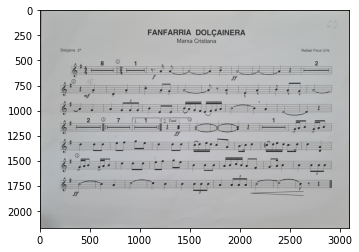

In [52]:
# apply the perspective transformation
warped = transform.four_point_transform(orig, screenCnt * ratio)

_=plt.imshow(warped)

# convert the warped image to grayscale
gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

# sharpen image
sharpen = cv2.GaussianBlur(gray, (0,0), 3)
sharpen = cv2.addWeighted(gray, 1.5, sharpen, -0.5, 0)

Transformamos la imagen para que tenga la forma de los contornos y poder escanearla y con la función **four_point_transform** corregimos la perspectiva para obtener una vista rectificada de la imagen del documento, eliminando así, cualquier distorsión causada por ángulos, luego le aplicamos un filtro gausiano para emborronarla un poquito y eliminar posible ruido, y con **cv2.addWeighted** aumentamos su nitidez, ya que toma la imagen original con un peso de 1.5 y resta la imagen desenfocada con un peso de -0.5. Este proceso realza los bordes y detalles de la imagen, mejorando su claridad.

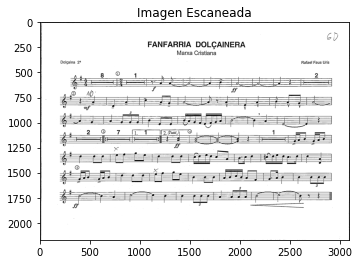

Se ha procesado partitura2.jpg


In [53]:
# Aplicamos threshhol adaptativo para ponerlo en blanco y negro
thresh = cv2.adaptiveThreshold(sharpen, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 10)
# Define the kernel for morphological operation
kernel = np.array([[0, 1, 0],
                   [1, 1, 1],
                   [0, 1, 0]], dtype=np.uint8)
# Aplicamos morfología para abrir la imagen
#opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
#blur = cv2.bilateralFilter(thresh,79,27,27)

plt.title('Imagen Escaneada')
plt.imshow(thresh, cmap="gray")

plt.show()

# save the cropped transformed image
basename = os.path.basename(image_path)
cv2.imwrite(OUTPUT_DIR + '/' + basename, thresh)
print("Se ha procesado " + basename)

Por último "escaneamos" el documento recortado, aunque realmente escanear es un efecto visual, ya que solo lo pasamos a una imagen en binaria, que tiene de valores 255 o 0. Con los valores 35 y 10 tienen una vital importancia, y hemos ido probando diferentes valores para ver la importancia que tenia, hay que entender que 35 es el tamaño del bloque de píxeles vecinos utilizados para calcular el umbral local para cada píxel, mientras que 10 es una constante que se resta del valor calculado por el método.

Hicimos pruebas con el blur ya que es un filtro que como vimos en las prácticas elimina ruido, a simple vista el ruido que teniamos si retamos el bloque es parecido, pero despues de aplicar el filtro vimos que no existe difrenecia alguna por lo que si no sirve, no se usa, aunque las pruebas estan ahí, para aprender.

De todas las pruebas que hemos estado haciendo los valores más equilibrados es un tamaño de bloque de 35 y una resta de 10, queda un tamaño de bloque muy bueno para los pentagramas y la imagen se escanea sin casi ruido.

### PRUEBAS

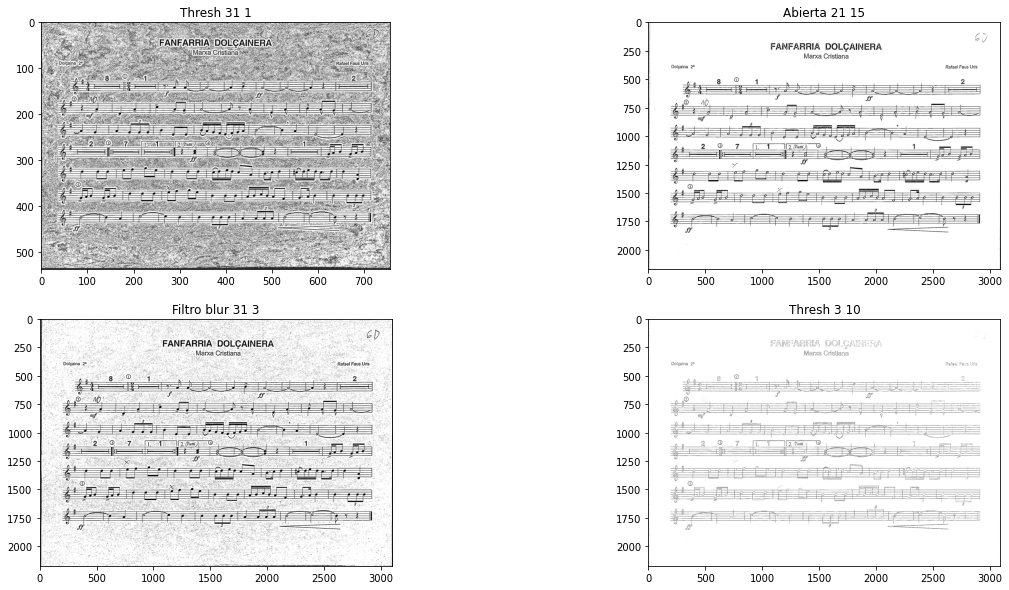

In [54]:
plt.figure(figsize=(20, 10))
image1_path = 'output/pruebas/thresh_31_1.jpeg' 
image1 = cv2.imread(image1_path)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
_=plt.subplot(2, 2, 1)
_=plt.title("Thresh 31 1")
_=plt.imshow(image1)

image2_path = 'output/pruebas/partitura2_opened_21_15.jpg' 
image2 = cv2.imread(image2_path)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
_=plt.subplot(2, 2, 2)
_=plt.title("Abierta 21 15")
_=plt.imshow(image2)

image3_path = 'output/pruebas/partitura2_blur_31_3.jpg' 
image3 = cv2.imread(image3_path)
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
_=plt.subplot(2, 2, 3)
_=plt.title("Filtro blur 31 3")
_=plt.imshow(image3)

image4_path = 'output/pruebas/partitura2_thresh_3_10.jpg'
image4 = cv2.imread(image4_path)
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)
_=plt.subplot(2, 2, 4)
_=plt.title("Thresh 3 10")
_=plt.imshow(image4)

## DETECTOR NOTAS MUSICALES

Vamos a crear un detector de notas musicales, usaremos algoritmos de detección para detectar las notas musicales

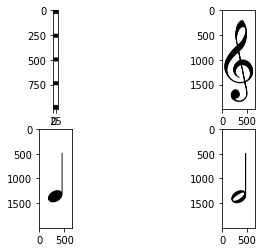

In [62]:
staff_img = cv2.cvtColor(cv2.imread("png/staff_.png"), cv2.COLOR_BGR2GRAY)
Gclef_img = cv2.cvtColor(cv2.imread("png/Gclef_.png"), cv2.COLOR_BGR2GRAY)
negra_img = cv2.cvtColor(cv2.imread("png/negra_.png"), cv2.COLOR_BGR2GRAY)
blanca_img = cv2.cvtColor(cv2.imread("png/blanca_.png"), cv2.COLOR_BGR2GRAY)

plt.subplot(221)
plt.imshow(staff_img, cmap="gray")
plt.subplot(222)
plt.imshow(Gclef_img, cmap="gray")
plt.subplot(223)
plt.imshow(negra_img, cmap="gray")
plt.subplot(224)
plt.imshow(blanca_img, cmap="gray")

In [63]:
np.unique(cv2.cvtColor(cv2.imread("png/staff_.png"), cv2.COLOR_BGR2GRAY))

array([  0, 255], dtype=uint8)

[ 3 63]


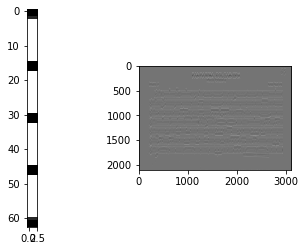

In [64]:
temp_size = np.array((1,21))*3
print(temp_size)
template = cv2.resize(staff_img, temp_size, interpolation = cv2.INTER_CUBIC)
plt.subplot(121)
plt.imshow(template, cmap="gray")
result = cv2.matchTemplate(thresh, template, cv2.TM_CCOEFF_NORMED)
plt.subplot(122)
plt.imshow(result, cmap="gray")

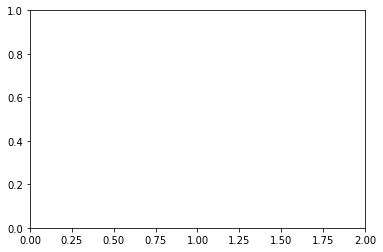

staff_img shape: (1000, 50)
Attempting resize with scale: 0.01
Error resizing image with scale 0.01: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4158: error: (-215:Assertion failed) !dsize.empty() in function 'cv::resize'

Attempting resize with scale: 0.04
scale: 0.04, hits: 1775


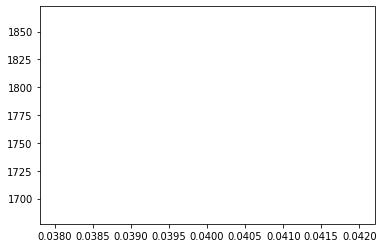

Attempting resize with scale: 0.07
scale: 0.07, hits: 0


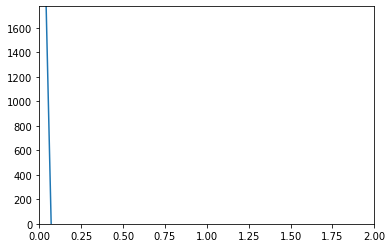

Attempting resize with scale: 0.1
scale: 0.1, hits: 0


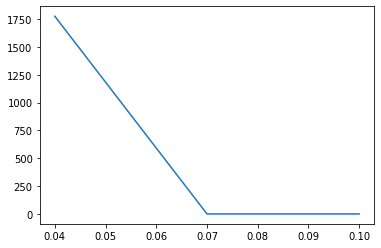

[(array([ 561,  561,  561, ..., 1734, 1734, 1734], dtype=int64), array([435, 436, 437, ..., 406, 407, 408], dtype=int64))] 0.04


In [67]:
ma, mi, th = 1, 10, 0.77
best_location_count = -1
best_locations = []
best_scale = 1

plt.axis([0, 2, 0, 1])
plt.show(block=False)

x = []
y = []

# Verificación inicial de staff_img
if staff_img is not None and staff_img.size > 0:
    staff_width, staff_height = staff_img.shape[::-1]

    # Imprimir información inicial de staff_img
    print(f"staff_img shape: {staff_img.shape}")

    for scale in [i / 100.0 for i in range(ma, mi + 1, 3)]:
        locations = []
        location_count = 0

        # Imprimir información de escala antes del resize
        print(f"Attempting resize with scale: {scale}")

        # Comprobación adicional de escala
        if scale <= 0:
            print(f"Invalid scale: {scale}")
            continue

        # Intentar redimensionar la imagen
        try:
            template = cv2.resize(staff_img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
        except cv2.error as e:
            print(f"Error resizing image with scale {scale}: {e}")
            continue

        result = cv2.matchTemplate(thresh, template, cv2.TM_CCOEFF_NORMED)
        result = np.where(result >= th)
        location_count += len(result[0])
        locations += [result]
        print("scale: {0}, hits: {1}".format(scale, location_count))
        x.append(location_count)
        y.append(scale)
        plt.plot(y, x)
        plt.pause(0.00001)
        if location_count > best_location_count:
            best_location_count = location_count
            best_locations = locations
            best_scale = scale
            plt.axis([0, 2, 0, best_location_count])
        elif location_count < best_location_count:
            pass
    plt.close()

    print(best_locations, best_scale)
else:
    print("Error: 'staff_img' is empty or not valid.")

In [ ]:
ma, mi, th = 50, 150, 0.77
def fit(img, templates, start_percent, stop_percent, threshold):
    img_width, img_height = img.shape[::-1]
    best_location_count = -1
    best_locations = []
    best_scale = 1

    plt.axis([0, 2, 0, 1])
    plt.show(block=False)

    x = []
    y = []
    for scale in [i/100.0 for i in range(start_percent, stop_percent + 1, 3)]:
        locations = []
        location_count = 0
        for template in templates:
            template = cv2.resize(template, None,
                fx = scale, fy = scale, interpolation = cv2.INTER_CUBIC)
            result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
            result = np.where(result >= threshold)
            location_count += len(result[0])
            locations += [result]
        print("scale: {0}, hits: {1}".format(scale, location_count))
        x.append(location_count)
        y.append(scale)
        plt.plot(y, x)
        plt.pause(0.00001)
        if (location_count > best_location_count):
            best_location_count = location_count
            best_locations = locations
            best_scale = scale
            plt.axis([0, 2, 0, best_location_count])
        elif (location_count < best_location_count):
            pass
    plt.close()

    return best_locations, best_scale

## MIDI TO AUDIO

Convertiremos un fichero MIDI (Musical Instrument Digital Interface) a un fichero WAV audible

In [26]:
!pip install midi2audio

In [27]:
import ejecutar as exc

In [30]:
midi_file = 'rick.mid'
wav_file = 'rick.wav'
sound_font =  'SoundFonts/MuseScore_General.sf2'

audio=exc.midi_to_wav(midi_file, wav_file, sound_font)